In [1]:
import sys
sys.path.append("../src")
sys.path.append("../data/embeddings")
import classifier
import svm_classifier
import debias
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity
import scipy
from scipy import linalg
from scipy.stats.stats import pearsonr
import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000

import warnings
warnings.filterwarnings("ignore")

In [2]:
def tsne_by_gender(vecs, labels, title):

  tsne = TSNE(n_components=2, random_state=0)
  vecs_2d = tsne.fit_transform(vecs)

  names = ["class 1", "class 2"]
  plt.figure(figsize=(6, 5))
  colors = 'r', 'b'
  for i, c, label in zip(range(10), colors, names):
    plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c, label=label, alpha = 0.2)
  plt.legend()
  plt.title(title)
  plt.show()
  return vecs_2d

### Data loading & processing

In [3]:
def load_word_vectors(fname = "../data/embeddings/vecs.filtered.txt"):
    
    model = KeyedVectors.load_word2vec_format(fname, binary=False)
    vecs = model.vectors
    words = list(model.vocab.keys())
    return model, vecs, words

def project_on_gender_subspaces(gender_vector, model: Word2VecKeyedVectors):
    
    group1 = model.similar_by_vector(gender_vector, topn = 3000, restrict_vocab=None)
    group2 = model.similar_by_vector(-gender_vector, topn = 3000, restrict_vocab=None)
    
    return group1, group2

def get_vectors(word_list: list, model: Word2VecKeyedVectors):
    
    vecs = []
    for w in word_list:
        
        vecs.append(model[w])
    
    vecs = np.array(vecs)
    return vecs


def save_in_word2vec_format(vecs: np.ndarray, words: np.ndarray, fname: str):


    with open(fname, "w", encoding = "utf-8") as f:

        f.write(str(len(vecs)) + " " + "300" + "\n")
        for i, (v,w) in tqdm.tqdm(enumerate(zip(vecs, words))):

            vec_as_str = " ".join([str(x) for x in v])
            f.write(w + " " + vec_as_str + "\n")

In [4]:
model, vecs, words = load_word_vectors(fname = "../data/embeddings/vecs.filtered.txt")
model_gendered, _, _ = load_word_vectors(fname = "../data/embeddings/vecs.gendered.txt")
gender_direction = model_gendered["he"] - model_gendered["she"]
gender_unit_vec = gender_direction/np.linalg.norm(gender_direction)

#gender_direction = model_gendered["he"] + model_gendered["man"] + model_gendered["boy"] + model_gendered["him"] - (model_gendered["she"] + model_gendered["woman"] + model_gendered["girl"] + model_gendered["her"])

masc_words_and_scores, fem_words_and_scores = project_on_gender_subspaces(gender_direction, model)
masc_words, masc_scores = list(zip(*masc_words_and_scores))
fem_words, fem_scores = list(zip(*fem_words_and_scores))

masc_vecs, fem_vecs = get_vectors(masc_words, model), get_vectors(fem_words, model)

print(masc_words[:25])
print("-------------------------")
print(fem_words[:25])

('journeyman', 'elder_statesman', 'fellow_countryman', 'endeared_himself', 'cult_hero', 'journeymen', 'swashbuckling', 'distanced_himself', 'prodigal_son', 'tradeable', 'prides_himself', 'hero', 'heir_apparent', 'elder_statesmen', 'benching', 'successor', 'burly', 'serviceable', 'jnr', 'goatee', 'league', 'training_camp', 'maestro', 'legendary', 'positional')
-------------------------
('alumna', 'beautician', 'motherly', 'petite', 'comedienne', 'saleswoman', 'songstress', 'ditzy', 'mommies', 'lip_gloss', 'perky', 'girlish', 'homemaker', 'bra', 'femininity', 'chanteuse', 'mums', 'pregnant', 'vivacious', 'breastfeeding', 'registered_nurse', 'catty', 'seamstress', 'tiara', 'spinster')


### Perform train-dev-test split

In [5]:
X = np.concatenate((masc_vecs, fem_vecs), axis = 0)
y_masc = np.zeros(masc_vecs.shape[0], dtype = int)
y_fem = np.ones(fem_vecs.shape[0], dtype = int)
y = np.concatenate((y_masc, y_fem))
X_train_dev, X_test, y_train_dev, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.4, random_state = 0)
X_train, X_dev, Y_train, Y_dev = sklearn.model_selection.train_test_split(X_train_dev, y_train_dev, test_size = 0.3, random_state = 0)
print("Train size: {}; Dev size: {}; Test size: {}".format(X_train.shape[0], X_dev.shape[0], X_test.shape[0]))

Train size: 2520; Dev size: 1080; Test size: 2400


### Debias

In [80]:
classifier_class = svm_classifier.SVMClassifier
num_classifiers = 40
input_dim = 300
is_autoregressive = True
min_accuracy = 0.48
add_noise = False
random_projection = False

P = debias.get_debiasing_projection(classifier_class, num_classifiers, input_dim, 
                                    is_autoregressive, min_accuracy, X_train, Y_train,
                                    X_dev, Y_dev, add_noise, random_projection)

Iteration 0, Accuracy: 1.0
Iteration 1, Accuracy: 0.8870370370370371
Iteration 2, Accuracy: 0.8388888888888889
Iteration 3, Accuracy: 0.7685185185185185
Iteration 4, Accuracy: 0.7240740740740741
Iteration 5, Accuracy: 0.6768518518518518
Iteration 6, Accuracy: 0.6296296296296297
Iteration 7, Accuracy: 0.5898148148148148
Iteration 8, Accuracy: 0.5648148148148148
Iteration 9, Accuracy: 0.5148148148148148
Iteration 10, Accuracy: 0.5175925925925926
Iteration 11, Accuracy: 0.5083333333333333
Iteration 12, Accuracy: 0.49444444444444446
Iteration 13, Accuracy: 0.4962962962962963
Iteration 14, Accuracy: 0.49722222222222223
Iteration 15, Accuracy: 0.5046296296296297
Iteration 16, Accuracy: 0.5064814814814815
Iteration 17, Accuracy: 0.49722222222222223
Iteration 18, Accuracy: 0.5138888888888888
Iteration 19, Accuracy: 0.5222222222222223
Iteration 20, Accuracy: 0.5342592592592592
Iteration 21, Accuracy: 0.5305555555555556
Iteration 22, Accuracy: 0.5148148148148148
Iteration 23, Accuracy: 0.5138888

### Test the quality of the debiasing.

#### Perform t-sne

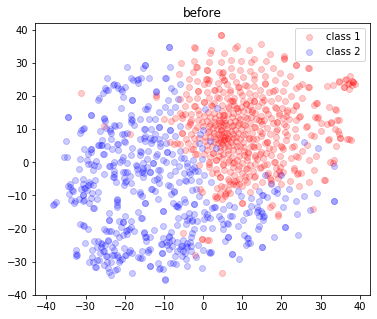

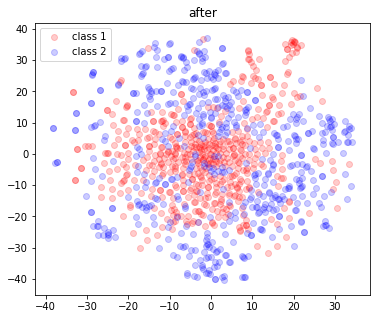

CALCULATING BIAS BY CLUSTERING (WITH K-MENAS)
NUM CLUSTERS = 2
Purity in original space: 0.9210562630034692
Purity after debiasing projection: 0.01248484497687146
NUM CLUSTERS = 10
Purity in original space: 0.8161063179989528
Purity after debiasing projection: 0.17001159328344484
NUM CLUSTERS = 25
Purity in original space: 0.8427286870121043
Purity after debiasing projection: 0.2415491429323431
NUM CLUSTERS = 100
Purity in original space: 0.8068166361244357
Purity after debiasing projection: 0.39989489779011367


In [81]:
def perform_purity_test(vecs, k, labels_true):
        np.random.seed(0)
        clustering = sklearn.cluster.KMeans(n_clusters = k)
        clustering.fit(vecs)
        labels_pred = clustering.labels_
        score = sklearn.metrics.homogeneity_score(labels_true, labels_pred)
        return score


tsne_by_gender(X_dev, Y_dev, title = "before")
X_dev_cleaned = X_dev.dot(P)
X_test_cleaned = X_test.dot(P)
X_trained_cleaned = X_train.dot(P)
tsne_projection = tsne_by_gender(X_dev_cleaned, Y_dev, title = "after")

NUM_CLUSTERS = [2,10,25,100]

print("CALCULATING BIAS BY CLUSTERING (WITH K-MENAS)")
for num_clusters in NUM_CLUSTERS:
    print("NUM CLUSTERS = {}".format(num_clusters))
    purity_original = perform_purity_test(X_dev, k = num_clusters, labels_true = Y_dev)
    purity_after = perform_purity_test(X_dev_cleaned, k = num_clusters, labels_true = Y_dev)
    print("Purity in original space: {}".format(purity_original))
    print("Purity after debiasing projection: {}".format(purity_after))

#### Train a nonlinear classifier for gender prediction.

In [82]:
#nonlinear_clf = MLPClassifier(hidden_layer_sizes = 128, activation = "relu")
nonlinear_clf = SVC(kernel = "rbf")
#nonlinear_clf = SGDClassifier(loss = "modified_huber", verbose = 0, max_iter = 5000, fit_intercept = True, class_weight = "balanced", penalty = "l2")
print("Before:")
nonlinear_clf.fit(X_train, Y_train)
print(nonlinear_clf.score(X_dev, Y_dev))

print("After, rbf-svm:")
nonlinear_clf = MLPClassifier(hidden_layer_sizes = 128, activation = "relu")
nonlinear_clf = SVC(kernel = "rbf")

nonlinear_clf.fit(X_trained_cleaned, Y_train)
print(nonlinear_clf.score(X_dev_cleaned, Y_dev))

print("After, mlp:")
nonlinear_clf = MLPClassifier(hidden_layer_sizes = 256, activation = "relu")

nonlinear_clf.fit(X_trained_cleaned, Y_train)
print(nonlinear_clf.score(X_dev_cleaned, Y_dev))

Before:
1.0
After, rbf-svm:
0.5027777777777778
After, mlp:
0.9416666666666667


#### project on the gender direction

In [83]:

masc_vecs_cleaned = masc_vecs.dot(P)
fem_vecs_cleaned = fem_vecs.dot(P)

print("masc-bias-before: {}".format(masc_vecs.dot(gender_unit_vec).mean()))
print("masc-bias-after: {}".format(masc_vecs_cleaned.dot(gender_unit_vec).mean()))
print("fem-bias-before: {}".format(fem_vecs.dot(gender_unit_vec).mean()))
print("fem-bias-after: {}".format(fem_vecs_cleaned.dot(gender_unit_vec).mean()))      

masc-bias-before: 0.37643688917160034
masc-bias-after: -0.01070005932279376
fem-bias-before: -0.6394068002700806
fem-bias-after: -0.01562662113495534


#### calculate the similarity matrix before and after

In [84]:

def get_distance_matrix(vecs: np.ndarray):

  distances = sklearn.metrics.pairwise_distances(vecs, vecs, metric="cosine")
  return distances

def plot_distance(distance_before, distance_after):

    idx = distance_before < 0.75 # we are only interested in the relatively close words

    distance_before = distance_before.copy()[idx]
    distance_after = distance_after.copy()[idx]
    
    chosen = np.random.rand(len(distance_before)) < 0.01
    before = distance_before[chosen]
    after = distance_after[chosen]
    plt.plot(before, after, linestyle="None", marker = "*", alpha = 0.1)
    plt.xlabel("distnace before")
    plt.ylabel("distance after")

    plt.show()
    print("Correlation: {}".format(pearsonr(before, after)[0]))
    
def plot_similarity_change_vs_original_bias(bias_before, distance_before, distance_after):

    K = 50
    most_similar_idx_before = distance_before.argsort(axis = 0)[:K].T
    most_similar_idx_after = distance_after.argsort(axis = 0)[:K].T
    data = []
    
    for i, (bias, dis_before, dis_after) in enumerate(tqdm.tqdm(zip(bias_before, distance_before, distance_after), ascii = True, total = len(bias_before))):
        
        idx_before = set(most_similar_idx_before[i].tolist())
        idx_after = set(most_similar_idx_after[i].tolist())
        intersection = (most_similar_idx_before[i] == most_similar_idx_after[i]).sum() 
        intersection = idx_before.intersection(idx_after)
        data.append((abs(bias), 1 - len(intersection)/K))
        #data.append((abs(bias), 1 - intersection/K))
        
    plt.xlabel("change in similarity (% of of top-{}-similar that changed)".format(K))
    plt.ylabel("bias before")
    biases, sims = zip(*data)    
    plt.plot(sims, biases, linestyle="None", marker = "*", alpha = 0.1)

    plt.show()
    print("Correlation: {}".format(pearsonr(biases, sims)[0]))

#### Plot similarity before vs. similarity after, and change of similarity vs. bias before

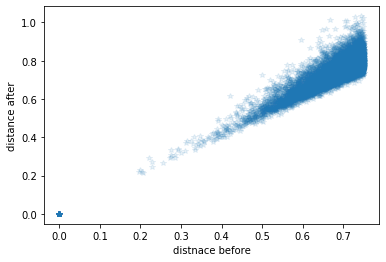

Correlation: 0.9143113593866198


100%|##########| 10152/10152 [00:00<00:00, 45881.42it/s]


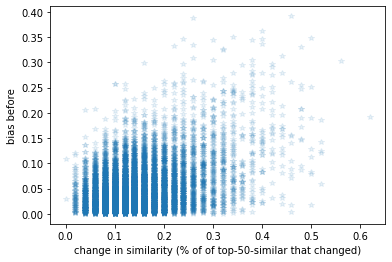

Correlation: 0.37380092108561114


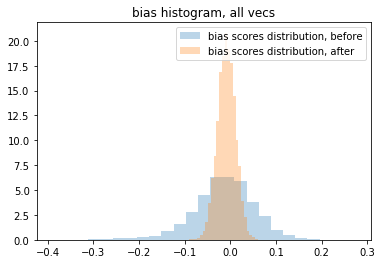

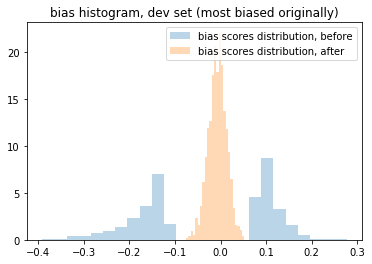

In [85]:
prop = 0.2
idx = np.random.rand(vecs.shape[0]) < prop
vecs_sample = vecs[idx]
words_sample = np.array(words, dtype = "object")[idx]

vecs_sample_cleaned = vecs_sample.dot(P)

distance_before = get_distance_matrix(vecs_sample)
distance_after = get_distance_matrix(vecs_sample_cleaned)

gender_unit_vec = gender_direction/np.linalg.norm(gender_direction)
sample_normalized = vecs_sample/np.linalg.norm(vecs_sample, axis = 1, keepdims = True)
sample_cleaned_normalized = vecs_sample_cleaned/np.linalg.norm(vecs_sample_cleaned, axis = 1, keepdims = True)

bias_before = sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(gender_direction, 0), vecs_sample)[0] #sample_normalized.dot(gender_unit_vec)
bias_after = sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(gender_direction, 0), vecs_sample_cleaned)[0] #sample_normalized.dot(gender_unit_vec)

plot_distance(distance_before.reshape(-1), distance_after.reshape(-1))
plot_similarity_change_vs_original_bias(bias_before, distance_before, distance_after)

# plot bias histograms before and after

# all vecs

plt.hist(bias_before, bins = 25, label = "bias scores distribution, before", alpha = 0.3, density = True)
plt.hist(bias_after, bins = 25, label = "bias scores distribution, after", alpha = 0.3, density = True)
plt.legend()
plt.title("bias histogram, all vecs")
plt.show()

# most originally biased (dev set)

bias_before_dev = sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(gender_direction, 0), X_dev)[0]
bias_after_dev = sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(gender_direction, 0), X_dev.dot(P))[0]

plt.hist(bias_before_dev, bins = 25, label = "bias scores distribution, before", alpha = 0.3, density = True)
plt.hist(bias_after_dev, bins = 25, label = "bias scores distribution, after", alpha = 0.3, density = True)
plt.legend()
plt.title("bias histogram, dev set (most biased originally)")
plt.show()


In [86]:
all_cleaned = vecs.dot(P)
save_in_word2vec_format(all_cleaned, words, "../data/embeddings/vecs.cleaned.txt")
model_cleaned, _, _ = load_word_vectors(fname = "../data/embeddings/vecs.cleaned.txt")

50000it [00:13, 3787.19it/s]


#### calcualte the similarity of female-stereotyped words to 'girlish', before and after

In [87]:
w = "girlish"
k = 200

random_fem_words = np.random.choice(fem_words, size = k)
sim_to_girlish_before = [model.similarity(w,w2) for w2 in random_fem_words]
sim_to_girlish_after = [model_cleaned.similarity(w,w2) for w2 in random_fem_words]

print("Similarity of female-stereotyped words to 'girlish' before: {}; similarity after: {}".format(np.mean(sim_to_girlish_before), np.mean(sim_to_girlish_after)))

Similarity of female-stereotyped words to 'girlish' before: 0.19757018983364105; similarity after: 0.004707296844571829


### Calcualte bias-by-clustering

In [88]:
def numerical_bias_by_clustering(model_before, model_after, masc_words, fem_words, k):
    
    scores_before, scores_after = [], []
    all_biased = masc_words.union(fem_words)
    
    for w in all_biased:
        
        most_similar_before = model_before.most_similar(w, topn = k)
        most_similar_before, _ = zip(*most_similar_before)

        most_similar_after = model_after.most_similar(w, topn = k)
        most_similar_after, _ = zip(*most_similar_after)
        
        neighbors_biased_before = len([w for w in most_similar_before if w in all_biased])
        neighbors_biased_after = len([w for w in most_similar_after if w in all_biased])
        scores_before.append(neighbors_biased_before)
        scores_after.append(neighbors_biased_after)
    print("avg. number of biased neighbors before: {}; after: {}".format(np.mean(scores_before), np.mean(scores_after)))
    
    
    
    

In [89]:
numerical_bias_by_clustering(model, model_cleaned, set(masc_words), set(fem_words), k = 1000)

avg. number of biased neighbors before: 229.71483333333333; after: 162.0565


#### print the most similar words to random words before and after (to make sure we didn't damage the space too much)

In [90]:
words_chosen = np.random.choice(words , size = 30)
topn = 8

for w in words_chosen:
    words_and_sims_before = model.most_similar(w, topn = topn)
    words__and_sims_after = model_cleaned.most_similar(w, topn = topn)
    words_before, _ = zip(*words_and_sims_before)
    words_after, _ = zip(*words__and_sims_after)
    print("w: {}\n most-similar-before: {}\n most-similar-after: {}".format(w,words_before, words_after))
    print("----------------------------------")

w: messenger
 most-similar-before: ('messengers', 'courier', 'god', 'emissary', 'mailman', 'couriers', 'assassin', 'missives')
 most-similar-after: ('messengers', 'courier', 'couriers', 'missives', 'emissary', 'messaging', 'conveying', 'message')
----------------------------------
w: rehabilitation
 most-similar-before: ('rehab', 'rehabilitating', 'rehabilitate', 'rehabilitative', 'rehabilitated', 'recuperation', 'detoxification', 'rehabs')
 most-similar-after: ('rehab', 'rehabilitating', 'rehabilitate', 'rehabilitative', 'rehabilitated', 'aftercare', 'recuperation', 'detoxification')
----------------------------------
w: outdoing
 most-similar-before: ('outdo', 'outdid', 'besting', 'outshone', 'outshining', 'rivaling', 'outshine', 'emulating')
 most-similar-after: ('outdo', 'outdid', 'besting', 'outshone', 'rivaling', 'outshining', 'emulating', 'surpassing')
----------------------------------
w: wavered
 most-similar-before: ('never_wavered', 'waver', 'fluctuated', 'waffled', 'waverin